# Analysis on laurel logs

In [1]:
import os
import sys
import numpy as np
import pandas as pd

In [2]:
sys.path.append('../')
sys.path.append('../src/')
sys.path.append('../spell/')

In [3]:
import Reader
import ParamsExtractor3
import DataPreprocessor
import DeepLearningAnomalyDetection2

2024-07-20 12:44:31.542326: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-20 12:44:31.592093: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-20 12:44:32.403945: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Training

In [4]:
log_types = ['laurel']
dates = ['20240418', '20240420', '20240429']
login_node_numbers = ['01', '02', '03', '10']

# Generate the list of file paths
file_paths = [f'/../../../temp_logs/{date}/login{num}.{logtype}.log' for date in dates for num in login_node_numbers for logtype in log_types]

# Filter the list to include only existing files
existing_file_paths = [path for path in file_paths if os.path.exists(path)]
print(existing_file_paths)

df_list = []

for file_path in existing_file_paths:
    r = Reader.Reader(file_path)
    df = r.read_file(file_path)
    df_list.append(df)

['/../../../temp_logs/20240418/login01.laurel.log', '/../../../temp_logs/20240418/login02.laurel.log', '/../../../temp_logs/20240418/login03.laurel.log', '/../../../temp_logs/20240418/login10.laurel.log', '/../../../temp_logs/20240420/login01.laurel.log', '/../../../temp_logs/20240420/login02.laurel.log', '/../../../temp_logs/20240420/login03.laurel.log', '/../../../temp_logs/20240420/login10.laurel.log']


In [5]:
len(df_list)

8

In [6]:
df_after = []

for i, df in enumerate(df_list):
    p = ParamsExtractor3.ParamsExtractor(df)
    df = p.convert_params(df)
    new_df = p.get_params()
    df_after.append(new_df)
    df_list[i] = pd.concat([df_list[i], new_df], axis=1)

In [7]:
df_list[0].head()

,host,ident,message,severity,facility,time,severity_numbers,facility_numbers,severity_scores,timedelta,suid,cap_fp,comm,parent_comm,exit,n_dang,n_dang_no_cron,fp_length
0,login01,laurel,"""1713391196.350:55343008"",""NODE"":""login01"",""SY...",info,local6,2024-04-18 00:00:03 +0200,6,22,1.0,0.0,126858,0,squeue,bash,0,2,0,92
1,login01,laurel,"""1713391198.212:55343009"",""NODE"":""login01"",""SY...",info,local6,2024-04-18 00:00:03 +0200,6,22,1.0,0.0,0,0,ping,pacemaker-execd,0,0,0,38
2,login01,laurel,"""1713391198.214:55343010"",""NODE"":""login01"",""SY...",info,local6,2024-04-18 00:00:03 +0200,6,22,1.0,0.0,0,0,basename,ping,0,0,0,28
3,login01,laurel,"""1713391198.220:55343011"",""NODE"":""login01"",""SY...",info,local6,2024-04-18 00:00:03 +0200,6,22,1.0,0.0,0,0,egrep,ping,0,0,0,28
4,login01,laurel,"""1713391198.221:55343012"",""NODE"":""login01"",""SY...",info,local6,2024-04-18 00:00:03 +0200,6,22,1.0,0.0,0,0,grep,ping,0,0,0,21


In [8]:
df_list[0].iloc[0]['message']

'"1713391196.350:55343008","NODE":"login01","SYSCALL":{"arch":"0xc000003e","syscall":59,"success":"yes","exit":0,"items":2,"ppid":29378,"pid":37632,"auid":126858,"uid":126858,"gid":25200,"euid":126858,"suid":126858,"fsuid":126858,"egid":25200,"sgid":25200,"fsgid":25200,"tty":"pts38","ses":703112,"comm":"squeue","exe":"/opt/slurm/23.11.5/bin/squeue","key":"auditcmd","ARCH":"x86_64","SYSCALL":"execve","AUID":"cmatteuc","UID":"cmatteuc","GID":"interactive","EUID":"cmatteuc","SUID":"cmatteuc","FSUID":"cmatteuc","EGID":"interactive","SGID":"interactive","FSGID":"interactive","ARGV":["0x564021c6aff0","0x564021c6bdf0","0x564021c34470","0x8"]},"EXECVE":{"argc":3,"ARGV":["squeue","-u","cmatteuc"],"ENV":{"LD_LIBRARY_PATH":"/g100_work/PROJECTS/spack/v0.17/prod/0.17.1/install/0.17/linux-centos8-skylake_avx512/gcc-8.4.1/anaconda3-2021.05-alnfpd33vtv6tt7sf6iq5ngwv7nqgeah/lib:/cineca/prod/opt/compilers/intel/oneapi-2022/binary/mpi/latest/libfabric/lib/prov:/cineca/prod/opt/compilers/intel/oneapi-2022

In [9]:
for i, df in enumerate(df_list):
    d = DataPreprocessor.DataPreprocessor(df)
    enc = d.drop_and_hash_encode()
    df_list[i] = enc

print(df_list[0].head())

   severity_scores  timedelta    suid  cap_fp      comm      parent_comm  \
0              1.0        0.0  126858       0    squeue             bash   
1              1.0        0.0       0       0      ping  pacemaker-execd   
2              1.0        0.0       0       0  basename             ping   
3              1.0        0.0       0       0     egrep             ping   
4              1.0        0.0       0       0      grep             ping   

   exit  n_dang  n_dang_no_cron  fp_length  ...  col_10  col_11  col_12  \
0     0       2               0         92  ...       0       0       0   
1     0       0               0         38  ...       0       0       0   
2     0       0               0         28  ...       0       0       0   
3     0       0               0         28  ...       0       0       0   
4     0       0               0         21  ...       0       0       0   

   col_13  col_14  col_15  col_16  col_17  col_18  col_19  
0       0       0       0       

In [10]:
for df in df_list:
    print(df.shape)

(1000, 30)
(1000, 30)
(1000, 30)
(1000, 30)
(1000, 30)
(1000, 30)
(1000, 30)
(1000, 30)


In [11]:
normal_dataset = df_list[0]

for i in range(1,len(df_list)):
    normal_dataset = np.vstack([normal_dataset, df_list[i]])

In [12]:
normal_dataset.shape

(8000, 30)

In [13]:
for df in df_list:
    total_nans = df.isna().sum().sum()
    print(f"Total number of NaNs: {total_nans}")

Total number of NaNs: 0
Total number of NaNs: 0
Total number of NaNs: 0
Total number of NaNs: 0
Total number of NaNs: 0
Total number of NaNs: 0
Total number of NaNs: 0
Total number of NaNs: 0


In [14]:
df_list[0].columns

Index(['severity_scores', 'timedelta', 'suid', 'cap_fp', 'comm', 'parent_comm',
       'exit', 'n_dang', 'n_dang_no_cron', 'fp_length', 'col_0', 'col_1',
       'col_2', 'col_3', 'col_4', 'col_5', 'col_6', 'col_7', 'col_8', 'col_9',
       'col_10', 'col_11', 'col_12', 'col_13', 'col_14', 'col_15', 'col_16',
       'col_17', 'col_18', 'col_19'],
      dtype='object')

In [15]:
normal_df = pd.DataFrame(normal_dataset)
normal_df.columns = df_list[0].columns

In [16]:
import EncodeCommand
encoder = EncodeCommand.EncodeCommand()

normal_df_encoded = encoder.encode_command(normal_df)
normal_df_encoded.fillna(-1, inplace=True)

normal_df_encoded.head()

,severity_scores,timedelta,suid,cap_fp,comm,parent_comm,exit,n_dang,n_dang_no_cron,fp_length,...,col_12,col_13,col_14,col_15,col_16,col_17,col_18,col_19,enc_comm,enc_parent_comm
0,1.0,0.0,126858,0,squeue,bash,0,2,0,92,...,0,0,0,0,1,0,0,0,1,39
1,1.0,0.0,0,0,ping,pacemaker-execd,0,0,0,38,...,0,0,0,0,1,0,0,0,2,125
2,1.0,0.0,0,0,basename,ping,0,0,0,28,...,0,0,0,0,1,0,0,0,3,2
3,1.0,0.0,0,0,egrep,ping,0,0,0,28,...,0,0,0,0,1,0,0,0,4,2
4,1.0,0.0,0,0,grep,ping,0,0,0,21,...,0,0,0,0,1,0,0,0,5,2


## Anomalies' dataset

In [17]:
log_types = ['laurel']

# Generate the list of file paths
file_paths = [f'../data/new_laurel_conf/audit.log' for logtype in log_types]

# Filter the list to include only existing files
existing_file_paths = [path for path in file_paths if os.path.exists(path)]
print(existing_file_paths)

an_df_list = []

for file_path in existing_file_paths:
    r = Reader.Reader(file_path)
    df = r.read_file(file_path)
    print(df.head())
    #df.columns = ['hostname', 'ident', 'message', 'severity', 'facility', 'time']
    an_df_list.append(df)

['../data/new_laurel_conf/audit.log']
                   ID                                            SYSCALL  \
0  1721464625.772:929  {'arch': '0xc000003e', 'syscall': 59, 'success...   
1  1721464625.816:930  {'arch': '0xc000003e', 'syscall': 59, 'success...   
2  1721464625.641:933  {'arch': '0xc000003e', 'syscall': 59, 'success...   
3  1721464625.512:934  {'arch': '0xc000003e', 'syscall': 59, 'success...   
4  1721464625.636:935  {'arch': '0xc000003e', 'syscall': 59, 'success...   

                                              EXECVE                      CWD  \
0  {'argc': 5, 'ARGV': ['/usr/bin/pkla-check-auth...             {'cwd': '/'}   
1  {'argc': 5, 'ARGV': ['/usr/bin/pkla-check-auth...             {'cwd': '/'}   
2  {'argc': 1, 'ARGV': ['/usr/libexec/gsd-rfkill'...  {'cwd': '/var/lib/gdm'}   
3  {'argc': 1, 'ARGV': ['/usr/libexec/gsd-sharing...  {'cwd': '/var/lib/gdm'}   
4  {'argc': 1, 'ARGV': ['/usr/libexec/gsd-keyboar...  {'cwd': '/var/lib/gdm'}   

                  

In [18]:
an_df_list[0].head()

,ID,SYSCALL,EXECVE,CWD,PATH,PROCTITLE,SERVICE_STOP,BPRM_FCAPS,SERVICE_START,SYSTEM_RUNLEVEL,...,USER_AUTH,USER_ACCT,CRED_ACQ,LOGIN,USER_ROLE_CHANGE,USER_START,USER_END,CRED_DISP,USER_CMD,CRED_REFR
0,1721464625.772:929,"{'arch': '0xc000003e', 'syscall': 59, 'success...","{'argc': 5, 'ARGV': ['/usr/bin/pkla-check-auth...",{'cwd': '/'},"[{'item': 0, 'name': '/usr/bin/pkla-check-auth...","{'ARGV': ['/usr/bin/pkla-check-authorization',...",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1721464625.816:930,"{'arch': '0xc000003e', 'syscall': 59, 'success...","{'argc': 5, 'ARGV': ['/usr/bin/pkla-check-auth...",{'cwd': '/'},"[{'item': 0, 'name': '/usr/bin/pkla-check-auth...","{'ARGV': ['/usr/bin/pkla-check-authorization',...",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1721464625.641:933,"{'arch': '0xc000003e', 'syscall': 59, 'success...","{'argc': 1, 'ARGV': ['/usr/libexec/gsd-rfkill'...",{'cwd': '/var/lib/gdm'},"[{'item': 0, 'name': '/usr/libexec/gsd-rfkill'...","{'ARGV': ['/bin/sh', '-e', '-u', '-c', 'export...",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1721464625.512:934,"{'arch': '0xc000003e', 'syscall': 59, 'success...","{'argc': 1, 'ARGV': ['/usr/libexec/gsd-sharing...",{'cwd': '/var/lib/gdm'},"[{'item': 0, 'name': '/usr/libexec/gsd-sharing...","{'ARGV': ['/bin/sh', '-e', '-u', '-c', 'export...",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1721464625.636:935,"{'arch': '0xc000003e', 'syscall': 59, 'success...","{'argc': 1, 'ARGV': ['/usr/libexec/gsd-keyboar...",{'cwd': '/var/lib/gdm'},"[{'item': 0, 'name': '/usr/libexec/gsd-keyboar...","{'ARGV': ['/bin/sh', '-e', '-u', '-c', 'export...",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
an_df_list[0].columns

Index(['ID', 'SYSCALL', 'EXECVE', 'CWD', 'PATH', 'PROCTITLE', 'SERVICE_STOP',
       'BPRM_FCAPS', 'SERVICE_START', 'SYSTEM_RUNLEVEL', 'BPF', 'USER_AUTH',
       'USER_ACCT', 'CRED_ACQ', 'LOGIN', 'USER_ROLE_CHANGE', 'USER_START',
       'USER_END', 'CRED_DISP', 'USER_CMD', 'CRED_REFR'],
      dtype='object')

In [20]:
an_df_list[0].iloc[0]

ID                                                 1721464625.772:929
SYSCALL             {'arch': '0xc000003e', 'syscall': 59, 'success...
EXECVE              {'argc': 5, 'ARGV': ['/usr/bin/pkla-check-auth...
CWD                                                      {'cwd': '/'}
PATH                [{'item': 0, 'name': '/usr/bin/pkla-check-auth...
PROCTITLE           {'ARGV': ['/usr/bin/pkla-check-authorization',...
SERVICE_STOP                                                      NaN
BPRM_FCAPS                                                        NaN
SERVICE_START                                                     NaN
SYSTEM_RUNLEVEL                                                   NaN
BPF                                                               NaN
USER_AUTH                                                         NaN
USER_ACCT                                                         NaN
CRED_ACQ                                                          NaN
LOGIN               

In [21]:
df = an_df_list[0]
# Extract the numeric part of the timestamp
df['timestamp'] = df['ID'].str.split(':').str[0].astype(float)

# Calculate the difference between consecutive timestamps
df['timedelta'] = df['timestamp'].diff()

In [22]:
df.head()

,ID,SYSCALL,EXECVE,CWD,PATH,PROCTITLE,SERVICE_STOP,BPRM_FCAPS,SERVICE_START,SYSTEM_RUNLEVEL,...,CRED_ACQ,LOGIN,USER_ROLE_CHANGE,USER_START,USER_END,CRED_DISP,USER_CMD,CRED_REFR,timestamp,timedelta
0,1721464625.772:929,"{'arch': '0xc000003e', 'syscall': 59, 'success...","{'argc': 5, 'ARGV': ['/usr/bin/pkla-check-auth...",{'cwd': '/'},"[{'item': 0, 'name': '/usr/bin/pkla-check-auth...","{'ARGV': ['/usr/bin/pkla-check-authorization',...",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.721465e+09,NaN
1,1721464625.816:930,"{'arch': '0xc000003e', 'syscall': 59, 'success...","{'argc': 5, 'ARGV': ['/usr/bin/pkla-check-auth...",{'cwd': '/'},"[{'item': 0, 'name': '/usr/bin/pkla-check-auth...","{'ARGV': ['/usr/bin/pkla-check-authorization',...",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.721465e+09,0.044
2,1721464625.641:933,"{'arch': '0xc000003e', 'syscall': 59, 'success...","{'argc': 1, 'ARGV': ['/usr/libexec/gsd-rfkill'...",{'cwd': '/var/lib/gdm'},"[{'item': 0, 'name': '/usr/libexec/gsd-rfkill'...","{'ARGV': ['/bin/sh', '-e', '-u', '-c', 'export...",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.721465e+09,-0.175
3,1721464625.512:934,"{'arch': '0xc000003e', 'syscall': 59, 'success...","{'argc': 1, 'ARGV': ['/usr/libexec/gsd-sharing...",{'cwd': '/var/lib/gdm'},"[{'item': 0, 'name': '/usr/libexec/gsd-sharing...","{'ARGV': ['/bin/sh', '-e', '-u', '-c', 'export...",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.721465e+09,-0.129
4,1721464625.636:935,"{'arch': '0xc000003e', 'syscall': 59, 'success...","{'argc': 1, 'ARGV': ['/usr/libexec/gsd-keyboar...",{'cwd': '/var/lib/gdm'},"[{'item': 0, 'name': '/usr/libexec/gsd-keyboar...","{'ARGV': ['/bin/sh', '-e', '-u', '-c', 'export...",NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.721465e+09,0.124


In [23]:
suid, cap_fp, comm, parent_comm, exit = -1,-1,-1,-1,-1

try:
    suid = an_df_list[0]['SYSCALL'].iloc[0]['suid']
except:
    pass

try:
    comm = an_df_list[0]['SYSCALL'].iloc[0]['comm']
except:
    pass

try:
    exit = an_df_list[0]['SYSCALL'].iloc[0]['exit']
except:
    pass

try:
    cap_fp = an_df_list[0]['PATH'].iloc[0][0]['cap_fp']
    cap_fp = int(cap_fp, 0)
except:
    pass

try:
    parent_comm = an_df_list[0]['PARENT_INFO'].iloc[0]['comm']
except:
    pass

params = [suid, cap_fp, comm, parent_comm, exit]
print(params)

[998, 0, 'pkla-check-auth', -1, 0]


In [24]:
an_df_list[0].iloc[0]['PATH'][0]['cap_fp']

'0x0'

In [27]:
def get_params_from_line(line):
    suid, cap_fp, comm, parent_comm, exit = -1,-1,-1,-1,-1

    #print(line[1]['SYSCALL'])
    #print('============')

    line = line[1]
    timedelta = line['timedelta']

    try:
        suid = line['SYSCALL']['suid']
    except:
        pass
    
    try:
        comm = line['SYSCALL']['comm']
    except:
        pass
    
    try:
        exit = line['SYSCALL']['exit']
    except:
        pass
    
    try:
        cap_fp = line['PATH'][0]['cap_fp']
        cap_fp = int(cap_fp, 0)
    except:
        pass
    
    try:
        parent_comm = line['PARENT_INFO']['comm']
    except:
        pass
    
    params = [timedelta, suid, cap_fp, comm, parent_comm, exit, -1, 0, 0, 0]
    #print(params)
    return params

In [28]:
data_list = []
for line in an_df_list[0].iterrows():
    params = get_params_from_line(line)
    data_list.append(params)

an_df = pd.DataFrame(data_list)
an_df.columns = ['timedelta', 'suid', 'cap_fp', 'comm', 'parent_comm', 'exit', 'log key', 'n_dang', 'n_dang_no_cron', 'fp_length']

In [29]:
an_df.head()

,timedelta,suid,cap_fp,comm,parent_comm,exit,log key,n_dang,n_dang_no_cron,fp_length
0,NaN,998,0,pkla-check-auth,-1,0,-1,0,0,0
1,0.044,998,0,pkla-check-auth,-1,0,-1,0,0,0
2,-0.175,42,0,gsd-rfkill,-1,0,-1,0,0,0
3,-0.129,42,0,gsd-sharing,-1,0,-1,0,0,0
4,0.124,42,0,gsd-keyboard,-1,0,-1,0,0,0


In [30]:
import EncodeCommand
encoder = EncodeCommand.EncodeCommand()

In [31]:
an_df.head()

,timedelta,suid,cap_fp,comm,parent_comm,exit,log key,n_dang,n_dang_no_cron,fp_length
0,NaN,998,0,pkla-check-auth,-1,0,-1,0,0,0
1,0.044,998,0,pkla-check-auth,-1,0,-1,0,0,0
2,-0.175,42,0,gsd-rfkill,-1,0,-1,0,0,0
3,-0.129,42,0,gsd-sharing,-1,0,-1,0,0,0
4,0.124,42,0,gsd-keyboard,-1,0,-1,0,0,0


In [32]:
anomalous_dataset_encoded = encoder.encode_command(an_df)

In [33]:
anomalous_dataset_encoded.head()

,timedelta,suid,cap_fp,comm,parent_comm,exit,log key,n_dang,n_dang_no_cron,fp_length,enc_comm,enc_parent_comm
0,NaN,998,0,pkla-check-auth,-1,0,-1,0,0,0,1,21
1,0.044,998,0,pkla-check-auth,-1,0,-1,0,0,0,1,21
2,-0.175,42,0,gsd-rfkill,-1,0,-1,0,0,0,2,21
3,-0.129,42,0,gsd-sharing,-1,0,-1,0,0,0,3,21
4,0.124,42,0,gsd-keyboard,-1,0,-1,0,0,0,4,21


In [34]:
anomalous_dataset_encoded.columns

Index(['timedelta', 'suid', 'cap_fp', 'comm', 'parent_comm', 'exit', 'log key',
       'n_dang', 'n_dang_no_cron', 'fp_length', 'enc_comm', 'enc_parent_comm'],
      dtype='object')

In [35]:
total_nans = anomalous_dataset_encoded.isna().sum().sum()
print(f"Total number of NaNs: {total_nans}")

Total number of NaNs: 1


## Library implementation

In [36]:
columns_for_laurel = ['timedelta','suid', 'cap_fp', 'exit', 'log key', 'n_dang',
       'n_dang_no_cron', 'fp_length', 'enc_comm', 'enc_parent_comm']

In [40]:
normal_dataset_df = pd.DataFrame(normal_df_encoded, columns=columns_for_laurel)
normal_dataset_df.fillna(-1, inplace=True)
anomalous_dataset_df = pd.DataFrame(anomalous_dataset_encoded, columns=columns_for_laurel)
anomalous_dataset_df.fillna(0, inplace=True)

In [41]:
normal_dataset_df.head()

,timedelta,suid,cap_fp,exit,log key,n_dang,n_dang_no_cron,fp_length,enc_comm,enc_parent_comm
0,0.0,126858,0,0,-1.0,2,0,92,1,39
1,0.0,0,0,0,-1.0,0,0,38,2,125
2,0.0,0,0,0,-1.0,0,0,28,3,2
3,0.0,0,0,0,-1.0,0,0,28,4,2
4,0.0,0,0,0,-1.0,0,0,21,5,2


In [42]:
anomalous_dataset_df.head()

,timedelta,suid,cap_fp,exit,log key,n_dang,n_dang_no_cron,fp_length,enc_comm,enc_parent_comm
0,0.000,998,0,0,-1,0,0,0,1,21
1,0.044,998,0,0,-1,0,0,0,1,21
2,-0.175,42,0,0,-1,0,0,0,2,21
3,-0.129,42,0,0,-1,0,0,0,3,21
4,0.124,42,0,0,-1,0,0,0,4,21


Mean normal reconstruction error: 0.0027108483754089054
Mean anomalous reconstruction error: 0.011026550555731443


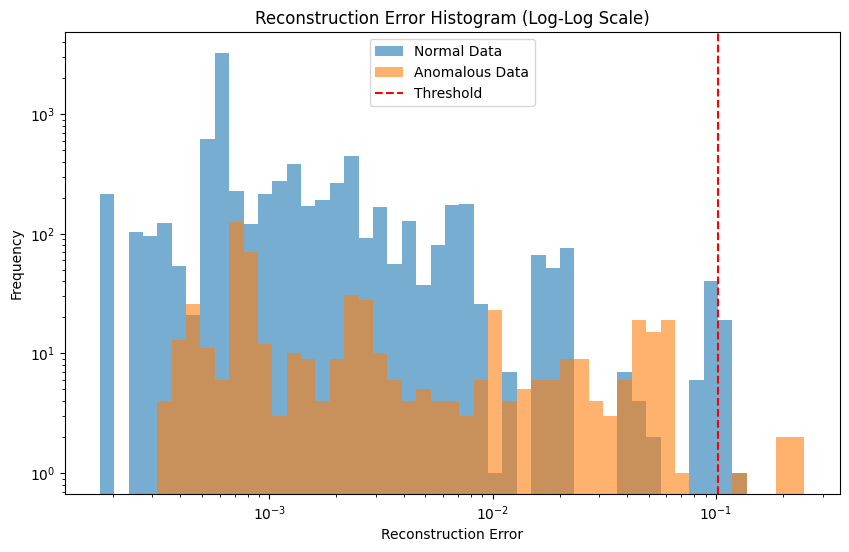

Threshold for anomaly detection: 0.1019177883016625
Number of anomalies detected: 5
Number of false positives detected: 20


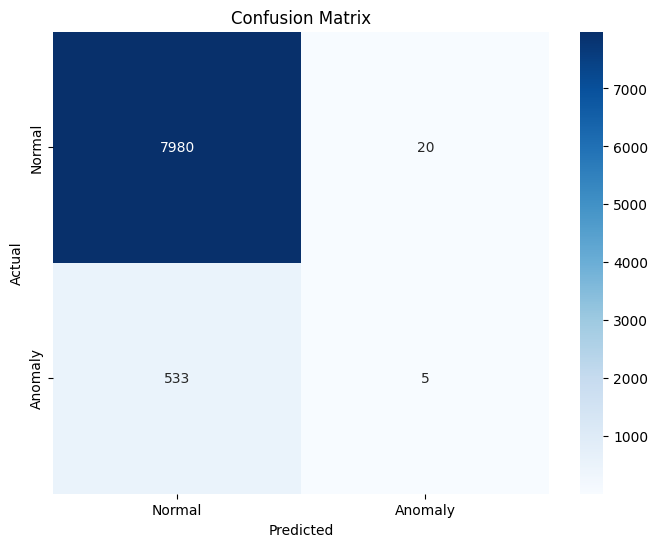

In [43]:
d_an_det = DeepLearningAnomalyDetection2.DeepLearningAnomalyDetection()
true_anomalies, reconstructed_anomalies, fp_ = d_an_det.train_test_model(normal_dataset_df, anomalous_dataset_df, 'autoencoder', laurel=1, plots=[0,0,1,1])

Mean normal reconstruction error: 0.023793504855007513
Mean anomalous reconstruction error: 0.02288233006626088


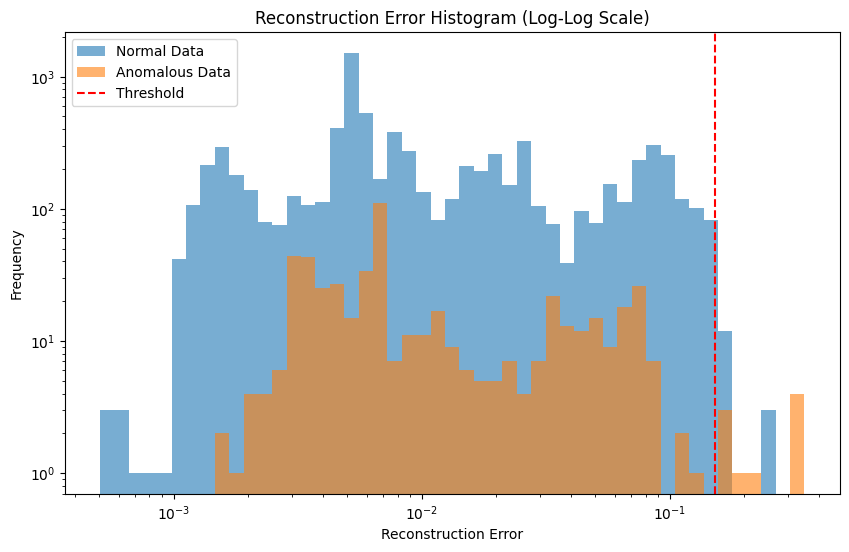

Threshold for anomaly detection: 0.15301217929781158
Number of anomalies detected: 9
Number of false positives detected: 20


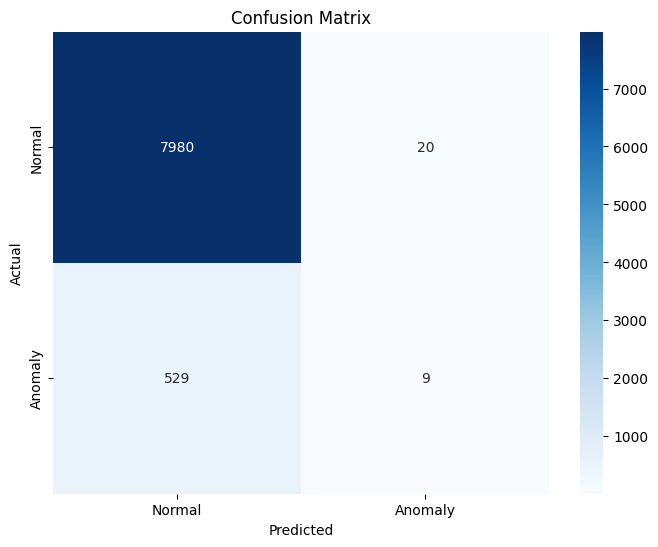

In [44]:
d_an_det = DeepLearningAnomalyDetection2.DeepLearningAnomalyDetection()
true_anomalies_vae, reconstructed_anomalies_vae, fp = d_an_det.train_test_model(normal_dataset_df, anomalous_dataset_df, 'vae', laurel=1, plots=[0,0,1,1])

In [ ]:
d_an_det.ensemble_method(normal_dataset_df, anomalous_dataset_df, plots=[1])

In [45]:
# Example predictions from two models (replace with your actual predictions)
predictions_model1 = reconstructed_anomalies
predictions_model2 = reconstructed_anomalies_vae

# Combine predictions using logical OR (voting scheme)
combined_predictions = np.logical_and(predictions_model1, predictions_model2).astype(int)

# Example thresholding (adjust as needed)
threshold = 0.5  # Simple majority voting

# Convert to final anomaly predictions based on threshold
final_predictions = (combined_predictions >= threshold).astype(int)

# Print or use the final predictions
print("Combined Predictions:", combined_predictions)
print("Final Anomaly Predictions:", final_predictions)

Combined Predictions: [0 0 0 ... 0 0 0]
Final Anomaly Predictions: [0 0 0 ... 0 0 0]


In [46]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

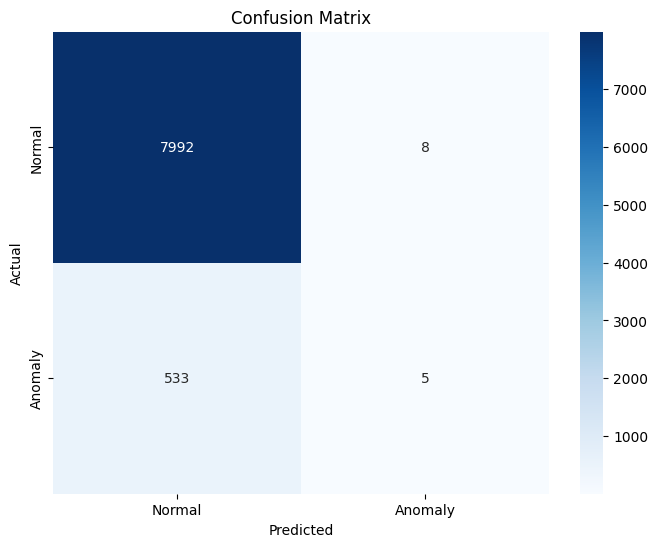

In [47]:
# Example ground truth and predictions (replace with your actual data)
ground_truth = true_anomalies
predictions = final_predictions
            
# Calculate confusion matrix
cm = confusion_matrix(ground_truth, predictions)
            
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                        xticklabels=['Normal', 'Anomaly'], 
                        yticklabels=['Normal', 'Anomaly'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

This makes extremely good sense because the anomalous dataset is normal, doesn't contain anomalies